<h1> Draft Master Thesis </h1>
Made by Jakob Lindstrøm and Marcus Hjertaas
<br>
<br>
This notebook shows how far we have come with our current work towards the master thesis, in regards of code. We are so to speak finished with data retrieval, Markowitz-algorithm and OGA-model. 
<br>
<br>
Exploratory data analysis, reinforcement learning algorithm and a comprehensive result (tables and plot) still remains. 

<h2> Current Content </h2>
We have retrieved data from a stock pool. We have traded thoose stocks with an Markowitz algorithm. We have performed the OGA model to look for allocation and selection effects. Where the benchmark is MPT and our experimental portfolio is a naive portfolio with equal weights (becuase RL is not finished). Lastly we show some plot to visualize how our result section might look like. 

<h2> Full access </h2>
To get full access to all code and modules; contact Jakob Lindstrøm. 

<h2> 1. Import libraries </h2>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import yfinance as yf

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

from Data_Retriever import DataRetriever as DatRet
from Markowitz_PT import MarkowitzPT as MPT
from Menchero_OGA import MencheroOGA as MOGA

<h2> 2. Define experimental variables </h2>

In [2]:
# Define number of trades
trading_n = 10

In [3]:
# Defining stock pool
ticker_df =  pd.DataFrame()
ticker_df["Petroleum"] = ["EQNR.OL", "AKRBP.OL", ]
ticker_df["Seafood (food)"] = ["ORK.OL", "LSG.OL"]
# ticker_df["Petroleum"] = ["EQNR.OL", "AKRBP.OL", "SUBC.OL", "BWO.OL",]
# ticker_df["Seafood (food)"] = ["ORK.OL", "MOWI.OL", "SALM.OL", "LSG.OL"]
# ticker_df["Materials"] = ["NHY.OL", "YAR.OL", "RECSI.OL", "BRG.OL"]
# ticker_df["Technologies"] = ["TEL.OL", "NOD.OL", "ATEA.OL", "BOUV.OL"]
# ticker_df["Financial"] = ["STB.OL", "DNB.OL", "GJF.OL", "MING.OL"]
# ticker_df["Shipping"] = ["WAWI.OL", "SNI.OL", "BELCO.OL", "ODF.OL"]
ticker_df

,Petroleum,Seafood (food)
0,EQNR.OL,ORK.OL
1,AKRBP.OL,LSG.OL


<h2> 3. Retrieve data </h2>

In [4]:
# Retrieve data from yf API: y-m-d
data = DatRet(ticker_df, "2012-10-01", "2025-02-18")

# In function below, set log=True to check for data availability
data.retrieve_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


'--Data retrieved successfully--'

<h2> 4. Frequency trading using MPT </h2>

In [5]:
len(data.returns[0])

2

In [6]:
data.returns

[[array([ 0.        ,  0.00745251, -0.00269005, ...,  0.00272378,
          0.00174615, -0.02130544]),
  array([ 0.        ,  0.0278075 , -0.01144668, ...,  0.00285713,
          0.00529597, -0.01167148])],
 [array([ 0.        ,  0.00823989,  0.00749156, ..., -0.00921659,
          0.00093022,  0.00371749]),
  array([ 0.        , -0.01666665,  0.00423723, ...,  0.01096889,
         -0.00542494, -0.00090908])]]

In [7]:
# Generate benchmark weights thorugh MPT using Sharpe ratio
benchmark = MPT(data.returns, 100, trading_n)
# IMPORTANT: In order to see  the effect of the weights, algo exclude last observation from optimization
benchmark.frequency_optimizing()

mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
mat form: 2
mat form: 100
decvar: [0.25 0.25 0.25 0.25]
--Frequency trading using MPT successfully performed--


<h2> 5. Conduct performance analysis </h2>

In [8]:
# Naive experimental portfolio
ew = [np.repeat(1/4, 4) for i in range(10)]
# Analysis 
analysis = MOGA(data.returns, benchmark.frequency_weights, ew)
# Frequency analysis
analysis.frequency_analyser()

--Frequency analysis performed succesfully--


<h2> X. Ad-hoc result analysis </h2> 

In [9]:
#Manual fixing weights
bw = [benchmark.frequency_weights[i][0] for i in range(0,10,1)]
ew = [np.repeat(1/4, 4) for i in range(10)]

# Manual fixing returns
return_array =  [pd.Series(stock)+1 for sector in data.returns for stock in sector]
return_df = pd.DataFrame(return_array)
return_tdf = return_df.T
ret = return_tdf[-10:]

In [10]:
# Replicate historic geometric returns
bg = np.cumprod([bw[i]@ret.iloc[i] for i in range(10)])
eg = np.cumprod([ew[i]@ret.iloc[i] for i in range(10)])

# Active return
active_return = np.cumprod(analysis.allocation_effects*analysis.selection_effects)

In [11]:
# Active return, but on portfolio level, not sector level
part1 = analysis.allocation_effects[::2] * analysis.allocation_effects[1::2]
part2 = analysis.selection_effects[::2] * analysis.selection_effects[1::2]
doublecheck = np.cumprod(part1*part2)

In [12]:
fig, ax = plt.subplots()
ax.plot(bg, color="grey", label="Benchmark")
ax.plot(eg, color="red", label="Experimental")
ax.plot(np.linspace(0,9,10),doublecheck, 
        color="orange", label= "Geometric active return")
# ax.plot(doublecheck*bg, label="doublecheck")
ax.set_xlabel("Trading operations")
ax.set_ylabel("Prc.chg Portfolio")
plt.title("Line plot for Proto-Portfolio")
plt.legend()
plt.close()

In [13]:
aa_petro = [analysis.allocation_effects[i] for i in range(0,20,2) ]
aa_seafood = [analysis.allocation_effects[i] for i in range(1,20,2)]
as_petro   =[analysis.selection_effects[i] for i in range(0,20,2) ]
as_seafood =  [analysis.selection_effects[i] for i in range(1,20,2)]

data_arrays = [aa_petro, aa_seafood, as_petro, as_seafood]
data_labels = ["Allo petro", "Allo seafood", "Sel petro", "Sel seafood"]

In [14]:
fig2, ax = plt.subplots(figsize=(8,5))
ax.boxplot(data_arrays, labels=data_labels)
plt.title("Boxplot for Proto-Portfolio")
plt.xlabel("Performance measures")
plt.ylabel("Returns")
plt.axhline(y=1, color="black" )
plt.close()

C:\Users\Jakob\AppData\Local\Temp\ipykernel_23624\1200690117.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_arrays, labels=data_labels)


<h2>Result and Comment Section </h2>

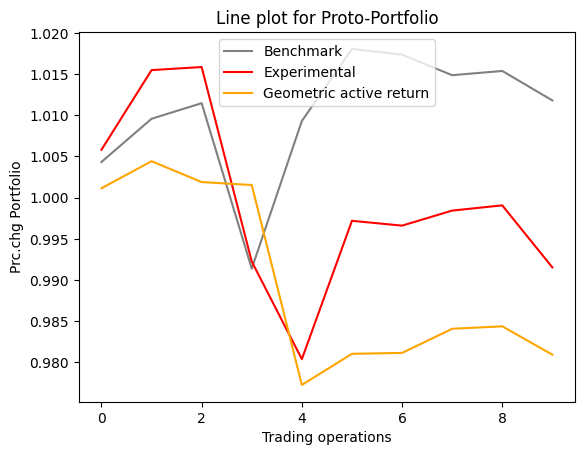

In [15]:
fig

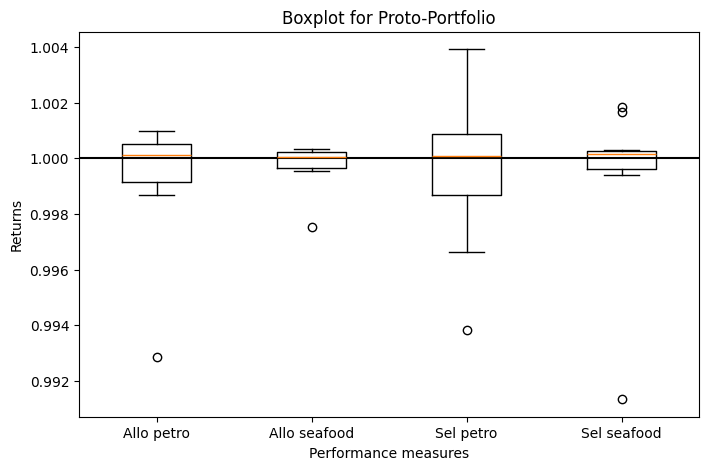

In [16]:
fig2